# چه عواملی باعث محبوبیت اپلیکیشن‌ها در پلی استور می‌شوند؟

Dataset: https://www.datacamp.com/datalab/datasets/dataset-python-google-play-store-apps

## آماده‌سازی و پاکسازی اولیه

#### ایمپورت و بارگذاری:

In [2]:
import pandas as pd

# خواندن فایل
df = pd.read_csv('googleplaystore.csv')

# ستون‌های مورد نیاز برای تحلیل اولیه
df = df[['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type', 'Price']]

#### حذف مقادیر خالی:

In [3]:
# حذف ردیف‌هایی که ستون App یا Category یا Rating یا Size یا Installs خالی دارن
df.dropna(subset=['App', 'Category', 'Rating', 'Size', 'Installs'], inplace=True)

###  پاک‌سازی خاص برای هر ستون:

#### Installs: تبدیل به عدد

##### ۱. حذف '+' و ','

In [4]:
df['Installs'] = df['Installs'].str.replace('[+,]', '', regex=True)

##### ۲. حذف ردیف‌هایی که واقعاً عدد نیستن

In [5]:
df = df[df['Installs'].str.isnumeric()]

##### ۳. تبدیل به عدد صحیح

In [6]:
df['Installs'] = df['Installs'].astype(int)

In [7]:
df['Installs'].head(10)

0       10000
1      500000
2     5000000
3    50000000
4      100000
5       50000
6       50000
7     1000000
8     1000000
9       10000
Name: Installs, dtype: int32

این کار:
-  فقط ردیف‌هایی رو نگه می‌داره که فقط عدد داره با '+' و ','

-  بعدش '+' و ',' رو حذف می‌کنیم و به int تبدیل میکنیم

#### Size: (تبدیل به عدد(به مگابایت

In [8]:
def convert_size(size):
    if size.endswith('M'):
        return float(size.replace('M', ''))
    elif size.endswith('k'):
        return float(size.replace('k', '')) / 1024
    elif size == 'Varies with device':
        return None
    else:
        return None

df['Size_MB'] = df['Size'].apply(convert_size)
df.dropna(subset=['Size_MB'], inplace=True)

#### Price: تبدیل به float 

بعضی مقدارهای این ستون اصلاً عددی هستن یا NaN، پس .str بهش نمی‌خوره

اول باید مطمئن بشیم که ستون ما تبدیل به رشته شده

اگه این کارو قبل از تبدیل به float انجام ندیم ارور زیر رو داریم:

Can only use .str accessor with string values

In [9]:
df['Price'] = df['Price'].astype(str).str.replace('$', '', regex=False).astype(float)

#### بررسی مقادیر Type

In [10]:
df['Type'].unique()

array(['Free', 'Paid'], dtype=object)

اگر مقدارهایی مثل زیر داریم، عالیه

'Free', 'Paid'

اگه مقدارهای مشکوک یا NaN هست → اون‌ها رو بررسی و حذف یا اصلاح می‌کنیم:

df = df[df['Type'].isin(['Free', 'Paid'])]

## تحلیل توصیفی و ویژوال

### سوال 1: کدوم اپ‌ها بیشترین دانلود رو داشتن؟

#### 1: پیدا کردن اپ‌های با بیشترین نصب (Top Apps)

In [11]:
df2= df.sort_values('Installs',ascending=False).drop_duplicates(subset='App', keep='first')

# انتخاب فقط یک رکورد (مثلاً پر دانلودترین) برای هر اپ
df_unique = df.sort_values('Installs', ascending=False).drop_duplicates(subset='App', keep='first')

top_apps = df_unique.sort_values('Installs', ascending=False).head(10)
top_apps[['App', 'Category', 'Installs', 'Rating', 'Size_MB', 'Type']]

,App,Category,Installs,Rating,Size_MB,Type
1917,Subway Surfers,GAME,1000000000,4.5,76.0,Free
9844,Google News,NEWS_AND_MAGAZINES,1000000000,3.9,13.0,Free
3569,Dropbox,PRODUCTIVITY,500000000,4.4,61.0,Free
1702,Pou,GAME,500000000,4.3,24.0,Free
4566,SHAREit - Transfer & Share,TOOLS,500000000,4.6,17.0,Free
4041,Temple Run 2,GAME,500000000,4.3,62.0,Free
383,imo free video calls and chat,COMMUNICATION,500000000,4.3,11.0,Free
3971,UC Browser - Fast Download Private & Secure,COMMUNICATION,500000000,4.5,40.0,Free
5596,Samsung Health,HEALTH_AND_FITNESS,500000000,4.3,70.0,Free
1705,Candy Crush Saga,GAME,500000000,4.4,74.0,Free


####  2: رسم نمودار ستونی

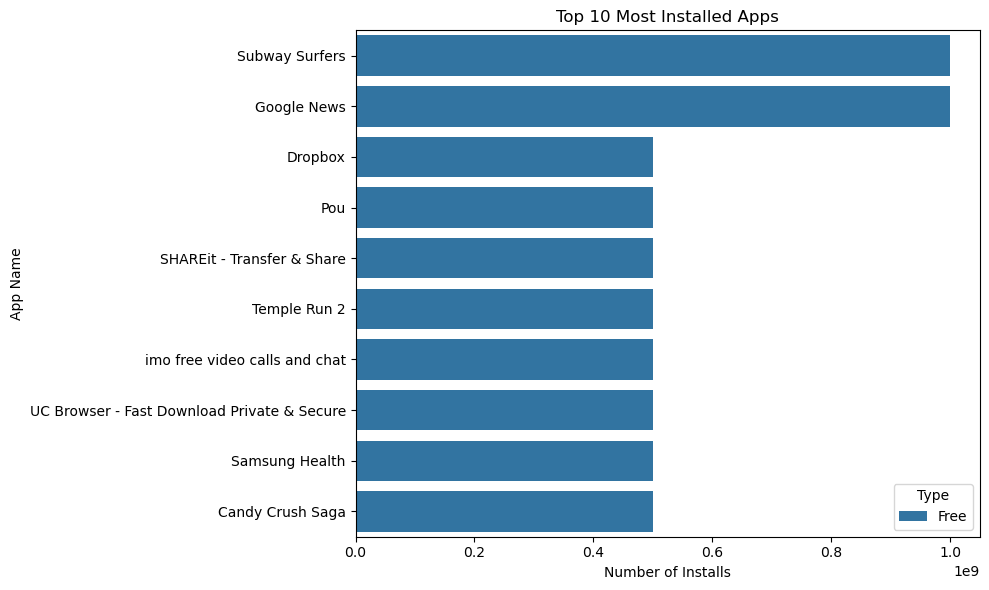

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.barplot(data=top_apps, y='App', x='Installs', hue='Type')

plt.title('Top 10 Most Installed Apps')
plt.xlabel('Number of Installs')
plt.ylabel('App Name')
plt.tight_layout()
plt.show()

### سوال 2: آیا حجم اپ بر تعداد دانلود آن تاثیر دارد؟

| سؤال                                                   | ابزار مناسب                         |
| ------------------------------------------------------ | ----------------------------------- |
| آیا حجم اپ روی تعداد دانلود اثر داره؟                  |  تحلیل تصویری (scatterplot, corr) |
| حجم بیشتر باعث دانلود بیشتر میشه؟                      |  تحلیل همبستگی (`corr()`)         |
| آیا می‌تونیم تعداد دانلود را از روی حجم پیش‌بینی کنیم؟ |  رگرسیون ساده یا چندگانه           |


از اونجا که سؤال ما اینه که حجم چه تأثیری روی دانلود داره؟:
- اول همبستگی و نمودار پراکندگی رو بررسی می‌کنیم
- اگر رابطه خاصی دیدیم، می‌ریم سراغ رگرسیون


#### ۱. نمودار پراکندگی (Scatter Plot)

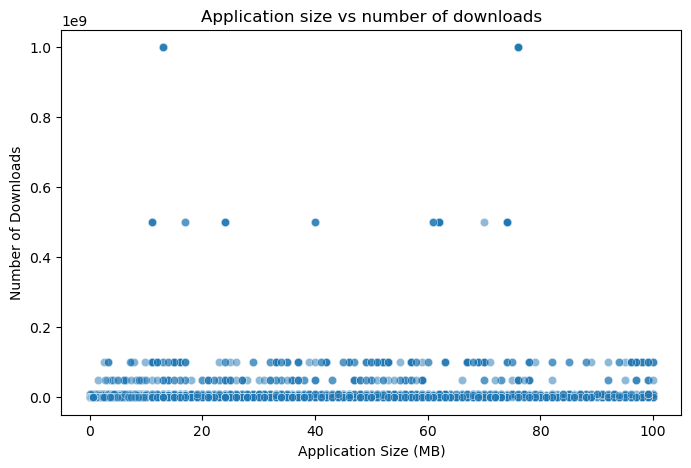

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Size_MB', y='Installs', alpha=0.5)

plt.title('Application size vs number of downloads')
plt.xlabel('Application Size (MB)')
plt.ylabel('Number of Downloads')
plt.show()

#### ۲. بررسی عددی رابطه با همبستگی (Correlation)

In [14]:
correlation = df['Size_MB'].corr(df['Installs'])
print(f'ضریب همبستگی بین حجم و تعداد نصب: {correlation:.2f}')

ضریب همبستگی بین حجم و تعداد نصب: 0.16


#### 3. تحلیل نتیجه:

**ضریب همبستگی:**

| مقدار همبستگی | تفسیر                                                                                                           |
| ------------- | --------------------------------------------------------------------------------------------------------------- |
| 🔹 `0.16`     | ضعیف و مثبت                                                                                                     |
| یعنی چی؟      | هرچند حجم اپ کمی با تعداد نصب رابطه داره، ولی خیلی قوی نیست                                                     |
| پس چی؟        | حجم بیشتر **کمی** باعث می‌شه اپ بیشتر دانلود بشه، ولی عوامل دیگه هم خیلی مهمن (مثل دسته، رایگان بودن، ریویو...) |


**نمودار پراکندگی:**

 دیدیم که نقاط پراکنده بودن:

رابطه واضحی نیست و شاید رگرسیون معنی‌دار نباشه

### سوال 3: آیا اپ‌های رایگان بیشتر دانلود می‌شن یا پولی؟ 

####  ۱. بررسی آماری میانگین نصب‌ها در هر نوع اپ (Free vs Paid)

In [51]:
df.groupby('Type')['Installs'].mean()
# به‌طور میانگین، اپ‌های رایگان چند بار نصب شدن و پولی‌ها چند بار

Type
Free    9.092723e+06
Paid    8.236594e+04
Name: Installs, dtype: float64

#### ۲. رسم نمودار برای مقایسه

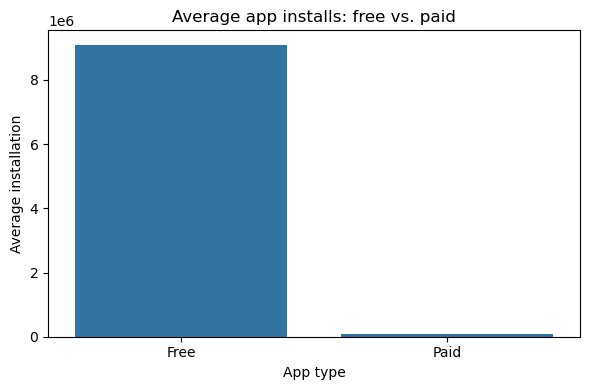

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.barplot(data=df, x='Type', y='Installs', estimator='mean', errorbar=None)

plt.title('Average app installs: free vs. paid')
plt.ylabel('Average installation')
plt.xlabel('App type')
plt.tight_layout()
plt.show()

#### 3.  آیا لازمه روی Type → Installs رگرسیون بزنیم؟

 نه، لزومی نداره — زیرا:
 
| دلیل                                        | توضیح                                                       |
| ------------------------------------------- | ----------------------------------------------------------- |
|  `Type` فقط دو دسته داره (`Free`, `Paid`) | یعنی یه متغیر **طبقه‌بندی‌شده (Categorical)** با ۲ مقدار    |
|  هدف ما فقط مقایسه میانگین‌ها بود         | نه پیش‌بینی دقیق نصب                                        |
|  رگرسیون بیشتر وقتی کاربرد داره که:       | بخوایم **پیش‌بینی عددی دقیق** کنیم، نه فقط بفهمیم کی بیشتره |


<br/>

**از نظر آماری، به جای رگرسیون، می‌توانیم با آزمون تی مقایسه بین دو گروه را بررسی کنیم که آیا اختلاف میانگین‌ها معناداره یا نه**

<br/>

| هدف پروژه                                  | لازمه t-test ?    |
| ------------------------------------------ | ---------------- |
| تمرین تحلیل داده، داشبورد، بینش از داده‌ها |  نه، کافی نیست  |
| تحلیل رسمی/علمی/مقاله یا گزارش مدیریتی     |  آره، ارزش داره |


این آزمون لازمه وقتی بخوایم به‌صورت علمی یا رسمی بگیم :

- «آیا تفاوت میانگین نصب بین اپ‌های رایگان و پولی تصادفی نیست؟»

- "این تفاوتی که دیدم به‌طور آماری معناداره یا ممکنه فقط یه اتفاق شانسی توی داده‌ها باشه؟"
  
**اگر فقط دنبال بینش کلی هستیم (و نه استنتاج آماری رسمی)، همون مقایسه‌ی میانگین و نمودار کافیه.**

ولی یه مورد تست میکنیم برای یادگیری بیشتر:

#### 4. آزمون t

بررسی می‌کنه آیا میانگین دو گروه واقعاً تفاوت داره یا اون اختلاف فقط تصادفیه

#####  ۱. آماده‌سازی داده‌ها

In [17]:
from scipy.stats import ttest_ind

# جدا کردن دو گروه
free = df[df['Type'] == 'Free']['Installs']
paid = df[df['Type'] == 'Paid']['Installs']

##### ۲. اجرای آزمون t

In [18]:
t_stat, p_value = ttest_ind(free, paid, equal_var=False)
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.5f}")

T-statistic: 14.62
P-value: 0.00000


#####  ۳. تفسیر

| مقدار                 | نتیجه                                                                                     |
| --------------------- | ----------------------------------------------------------------------------------------- |
| `p-value ≈ 0.00000`   | یعنی احتمال اینکه تفاوت میانگین نصب بین اپ‌های رایگان و پولی **تصادفی باشه تقریباً صفره** |
| `T-statistic = 14.62` | قدرت این تفاوت بسیار زیاد بوده                                                            |


| مقدار         | معنی                 |
| ------------- | -------------------- |
|  `p < 0.05` | تفاوت معنادار است   |
|  `p > 0.05` | تفاوت معنادار نیست  |


| مقدار α | تفسیر                                     |
| ------- | ----------------------------------------- |
| 0.05    | رایج‌ترین سطح معنی‌داری (۵٪ خطای نوع اول) |
| 0.01    | سطح سخت‌گیرانه‌تر (۱٪ احتمال خطا)         |
| 0.001   | سطح بسیار محافظه‌کارانه                   |


##### 4. نتیجه

اپ‌های رایگان به‌طور آماری معنادار، بیشتر از اپ‌های پولی نصب می‌شن

### سوال 4: آیا ریویوهای کاربران به حجم اپ ربط دارد؟

#### 1) آیا تعداد ریویو به حجم مرتبط است؟

##### تبدیل Reviews به عدد صحیح

In [19]:
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

##### رسم scatterplot برای دیدن رابطه حجم و ریویو

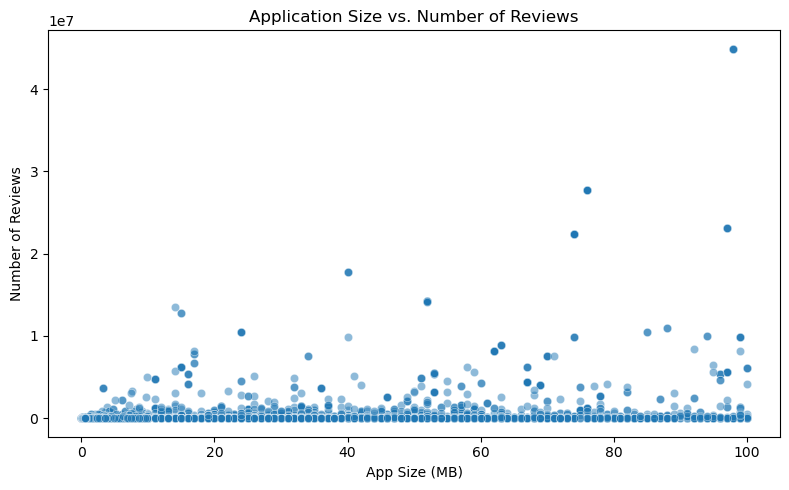

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x='Size_MB', y='Reviews', alpha=0.5)

plt.title('Application Size vs. Number of Reviews')
plt.xlabel('App Size (MB)')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()

##### محاسبه ضریب همبستگی

In [21]:
correlation = df['Size_MB'].corr(df['Reviews'])
print(f'ضریب همبستگی حجو و ریویو: {correlation: .2f}')

ضریب همبستگی حجو و ریویو:  0.24


##### نتیجه

| مقدار همبستگی | تفسیر                                                                                     |
| ------------- | ----------------------------------------------------------------------------------------- |
| `0.24`        | ضعیف تا متوسط، **مثبت**                                                                   |
| یعنی چی؟      | هرچقدر اپ سنگین‌تر (حجم بیشتر)، احتمال اینکه **کاربران بیشتر نظر بدن** هم کمی بیشتر می‌شه |
| پس چی؟        | حجم بالا ممکنه باعث بشه کاربران **بیشتر واکنش نشون بدن**—خوب یا بد!                       |


- شاید اپ‌های سنگین‌تر تجربه‌های متفاوت‌تری ایجاد می‌کنن (مثلاً بازی‌ها با گرافیک بالا)، به همین دلیل ریویوی بیشتری می‌گیرن

- یا شاید کاربران برای اپ‌های با حجم بالا سخت‌گیرترن و بیشتر ریویو می‌ذارن

#### 2) تحلیل متنی ریویوها نسبت به حجم

##### **آماده سازی داده ها**

In [22]:
# خواندن فایل دوم
reviews = pd.read_csv("googleplaystore_user_reviews.csv")
reviews = reviews[['App', 'Translated_Review', 'Sentiment']]
reviews.dropna(subset=['Translated_Review', 'Sentiment'], inplace=True)

# ادغام با دیتاست اول
df_merge = pd.merge(reviews, df[['App', 'Size_MB']], on='App', how='inner')

##### **تحلیل احساس نسبت به حجم**

In [23]:
# دسته‌بندی اپ‌ها به سبک و سنگین
df_merge['Size_Category'] = pd.cut(df_merge['Size_MB'], bins=[0, 20, 40, 1000], labels=['Light', 'Medium', 'Heavy'])

#  bins داده‌های پیوسته (مثل درآمد یا سن) رو به بازه‌های گسسته تقسیم میکند

In [24]:
# جدول فراوانی Sentiment در هر گروه
sent_by_size = pd.crosstab(df_merge['Size_Category'], df_merge['Sentiment'], normalize='index')
print(sent_by_size)

Sentiment      Negative   Neutral  Positive
Size_Category                              
Light          0.192292  0.146219  0.661489
Medium         0.223798  0.128785  0.647416
Heavy          0.363134  0.064110  0.572756


- pd.crosstab(...) :

جدول شمارش فراوانی برای ترکیب دو ستون را می‌سازد.

- normalize='index':

 این باعث می‌شه که مقادیر به‌صورت درصد (نرمال شده) برای هر ردیف (سایز اپ) حساب بشن — جمع هر ردیف = ۱

| گروه حجم           | درصد نظرات منفی | درصد نظرات مثبت | برداشت                          |
| ------------------ | --------------- | --------------- | ------------------------------- |
| **Light (کم‌حجم)** | 19%             |  66%          | کاربران بیشتر راضی هستن         |
| **Medium (متوسط)** | 22%             | 64%             | کمی افت رضایت                   |
| **Heavy (پر‌حجم)** |  **36%**      | 57%             | نظرات منفی **به‌شدت بیشتر** شده |



**«تحلیل احساس کاربران نشون می‌ده اپ‌های پر‌حجم، تقریباً دو برابر بیشتر نظرات منفی نسبت به اپ‌های سبک دارن.»**

 این می‌تونه چند دلیل داشته باشه:

-  اپ‌های سنگین شاید سخت‌تر اجرا شن یا باگ بیشتری داشته باشن

-  کاربران روی مصرف دیتا و حافظه حساس‌تر می‌شن

**نتیجه:**

  از حجم میتونیم به‌عنوان یک ویژگی تأثیرگذار روی رضایت توی مدلسازی استفاده کنیم

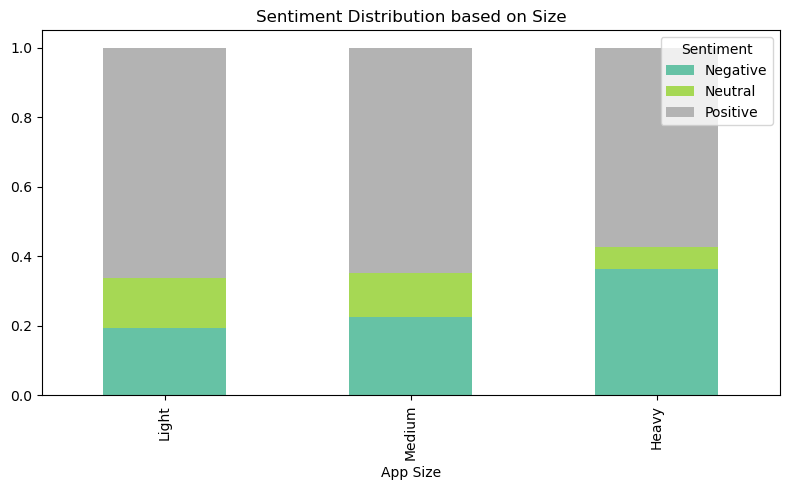

In [52]:
# نمودار
sent_by_size.plot(kind='bar', stacked=True, figsize=(8,5), colormap='Set2')
plt.title('Sentiment Distribution based on Size')
plt.xlabel('App Size')
plt.legend(title='Sentiment')
plt.tight_layout()
plt.show()

##### **پرتکرارترین کلمات در اپ‌های سنگین و سبک**

In [26]:
# تقسیم اپ‌ها
light = df_merge[df_merge['Size_Category'] == 'Light']['Translated_Review']
heavy = df_merge[df_merge['Size_Category'] == 'Heavy']['Translated_Review']

In [53]:
# نصب کتابخانه wordcloud
!pip install wordcloud

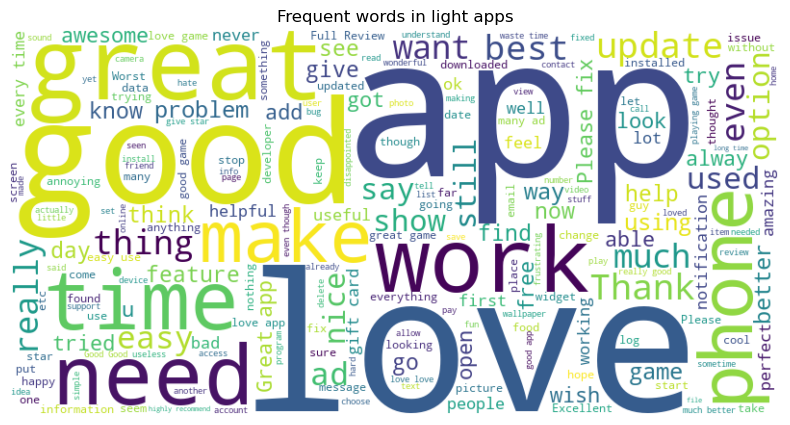

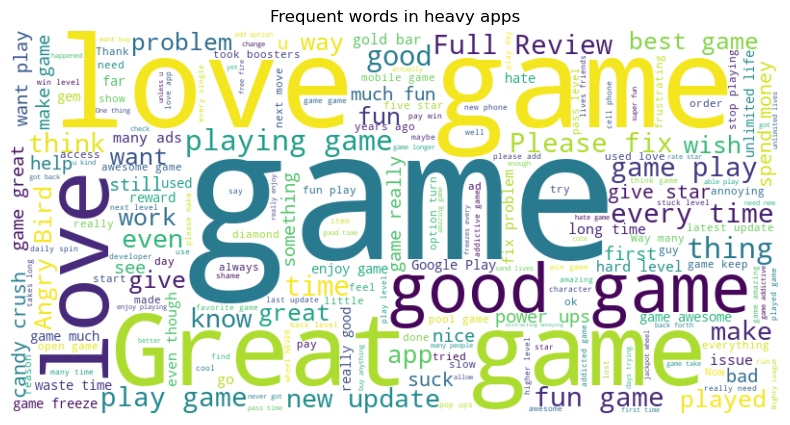

In [54]:
# تولید  WordCloud
from wordcloud import WordCloud

def show_wordcloud(text, title):
    text = ' '.join(text.dropna().astype(str))
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

show_wordcloud(light, 'Frequent words in light apps')
show_wordcloud(heavy, 'Frequent words in heavy apps')

**نتیجه نهایی:**

«کاربران در اپ‌های سبک به نسبت اپ های سنگین، بیشتر احساس راحتی و رضایت دارن»

### سوال 5: در کدوم دسته از اپ‌ها، نسبت نظرات منفی بیشتره؟

#### مرحله 1: ادغام دسته‌بندی با نظرات

In [29]:
# دیتاستِ نظرات، ستون "دسته" نداره، پس باید از دیتاست اصلی بیاریمش:
df_for_sentiment = pd.merge(reviews, df[['App', 'Category']], on='App', how='inner')

#### مرحله 2: جدول فراوانی احساسات برای هر دسته

In [30]:
sentiment_by_cat = pd.crosstab(df_for_sentiment['Category'], df_for_sentiment['Sentiment'], normalize='index') 
sentiment_by_cat

Sentiment,Negative,Neutral,Positive
Category,,,
ART_AND_DESIGN,0.168116,0.156522,0.675362
AUTO_AND_VEHICLES,0.067073,0.121951,0.810976
BEAUTY,0.188742,0.274834,0.536424
BOOKS_AND_REFERENCE,0.085987,0.175159,0.738854
BUSINESS,0.164099,0.201079,0.634823
COMICS,0.000000,0.400000,0.600000
COMMUNICATION,0.135889,0.151568,0.712544
DATING,0.202708,0.163164,0.634129
EDUCATION,0.111307,0.160777,0.727915


#### مرحله 3: رسم نمودار دسته‌ها با بالاترین نظرات منفی

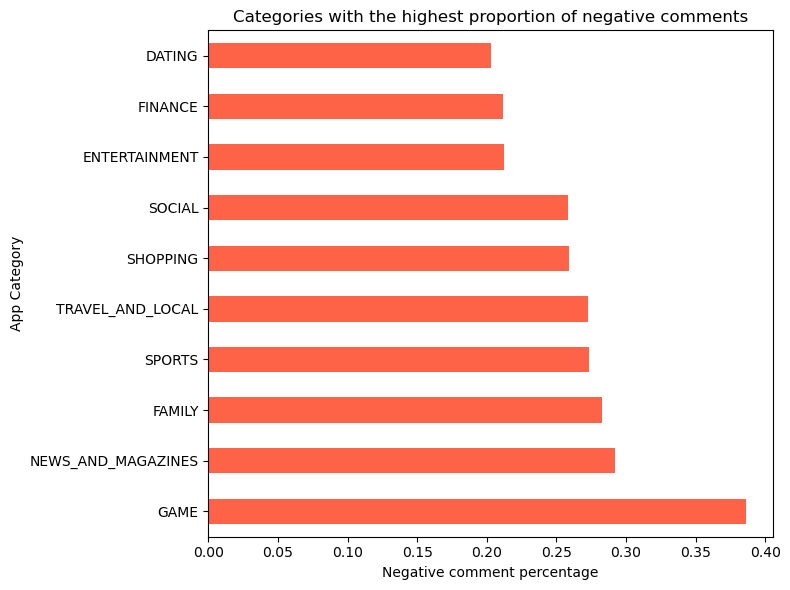

In [31]:
top_negative = sentiment_by_cat['Negative'].sort_values(ascending=False).head(10)

top_negative.plot(kind='barh', figsize=(8,6), color='tomato')
plt.title('Categories with the highest proportion of negative comments')
plt.xlabel('Negative comment percentage')
plt.ylabel('App Category')
plt.tight_layout()
plt.show()

| رتبه | دسته (Category)          | نسبت نظرات منفی |
| ---- | ------------------------ | --------------- |
| 1️⃣  | **GAME**                 | 38.6%           |
| 2️⃣  | **NEWS\_AND\_MAGAZINES** | 29.2%           |
| 3️⃣  | **FAMILY**               | 28.2%           |
| 4️⃣  | **SPORTS**               | 27.3%           |
| 5️⃣  | **TRAVEL\_AND\_LOCAL**   | 27.2%           |
| 6️⃣  | **SHOPPING**             | 25.9%           |
| 7️⃣  | **SOCIAL**               | 25.8%           |
| 8️⃣  | **ENTERTAINMENT**        | 21.2%           |
| 9️⃣  | **FINANCE**              | 21.1%           |
| 🔟   | **DATING**               | 20.2%           |


 چرا بازی بالاترین نظرات منفی رو داره؟

- کاربران گیمر معمولاً سخت‌گیرترن

-   ممکنه باگ زیاد باشه یا تبلیغات آزاردهنده

-  حجم بالا و عملکرد پایین 

🔺 News, Family, Sports :

-  در دسته اخبار و خانواده، شاید افراد انتظار تجربه ای راحت دارن

 -   اپ‌های خبری گاهی کند هستن یا باگ دارن

 -   اپهای ورزشی و همچنین اپ های مربوط به سفر معمولاً نیاز به آپدیت و دقت دارن، ضعف در اینها باعث شکایت می‌شه


در نهایت:

**دسته بازی با بیش از 38٪ نظرات منفی، بالاترین نرخ نارضایتی کاربران را دارد**

**اخبار، خانواده، ورزش و سفر نیز در میان دسته‌های با نرخ شکایت بالا در رتبه های بعدی هستند**

## الگوریتم Classification

-  **Regression**:
    - اگر بخوایم مثلاً تعداد نصب اپ ها یا امتیاز رو پیش‌بینی کنیم

-  **Classification**:
    - اگه بخوایم نظر کاربر (مثبت/منفی) یا دسته اپ رو پیش‌بینی کنیم

-  **Clustering**:
    - برای کشف الگوها یا گروه‌های پنهان اپ‌ها، بدون برچسب


**چون تا اینجا خیلی تحلیلی کار کردیم، و برچسب‌هایی مثل Rating یا Sentiment داریم:**

 **Classification** → پیش‌بینی نظر کاربر (مثبت/منفی) از روی ویژگی‌های اپ گزینه بهتریه

### RandomForest

چرا Random Forest?

| ویژگی                                                | دلیل انتخاب                                                 |
| ---------------------------------------------------- | ----------------------------------------------------------- |
|  **دقت خوب برای داده‌های ترکیبی (عددی + متنی)**    | ما `Size`, `Rating`, `Category`, `Type` داریم              |
|  **توانایی مدل‌کردن روابط غیرخطی**                 | مثلاً ترکیب `Category` و `Rating` ممکنه روی نظر تأثیر بذاره |
|  **مقاوم در برابر Overfitting نسبت به درخت تکی**   | چون درخت‌های زیادی ترکیب می‌شن                              |
|  **اوتوماتیک مهم‌ترین ویژگی‌ها رو شناسایی می‌کنه** | برای مرحله بعد تحلیل Feature Importance عالیه!              |


####  مرحله 1: آماده‌سازی داده

##### **1.1 ادغام دیتاست‌ها:**

In [32]:
df_clf = pd.merge(reviews, df[['App', 'Category', 'Size_MB', 'Type', 'Rating']], on='App', how='inner')
df_clf.dropna(subset=['Sentiment'], inplace=True)

##### **1.2 انتخاب ویژگی‌ها و هدف:**

In [33]:
df_clf = df_clf[df_clf['Sentiment'].isin(['Positive', 'Negative'])]  # فقط دو کلاس

##### **1.3 برچسب‌گذاری خروجی:**

In [34]:
df_clf['Sentiment_Label'] = df_clf['Sentiment'].map({'Positive': 1, 'Negative': 0})

#### مرحله 2: تبدیل ویژگی‌های متنی به عددی

In [35]:
from sklearn.preprocessing import LabelEncoder

le_cat = LabelEncoder()
df_clf['Category_Code'] = le_cat.fit_transform(df_clf['Category'])

le_type = LabelEncoder()
df_clf['Type_Code'] = le_type.fit_transform(df_clf['Type'])

#### مرحله 3: ساخت X و y

In [36]:
X = df_clf[['Size_MB', 'Rating', 'Category_Code', 'Type_Code']]
y = df_clf['Sentiment_Label']

#### مرحله 4: تقسیم داده، آموزش مدل و ارزیابی

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

#### مرحله 5: ارزیابی مدل

In [38]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7202351175587793

Confusion Matrix:
 [[ 711 1575]
 [ 662 5048]]

Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.31      0.39      2286
           1       0.76      0.88      0.82      5710

    accuracy                           0.72      7996
   macro avg       0.64      0.60      0.60      7996
weighted avg       0.69      0.72      0.70      7996



**تحلیل خروجی مدل**

 Accuracy: 0.72

- یعنی مدل به‌طور کلی در 72٪ موارد احساس مثبت یا منفی کاربر رو درست پیش‌بینی کرده
-  برای داده‌ی واقعی با نویز زیاد عدد بدی نیست


Confusion Matrix:

                   Predicted
                   0     1
    Actual  0     711   1575
            1     662   5048

        
| کلاس              | تفسیر                                                                                         |
| ----------------- | --------------------------------------------------------------------------------------------- |
| کلاس 0 = Negative | مدل خیلی ضعیف عمل کرده. Recall فقط 31٪ یعنی بیشتر نظرات منفی رو **اشتباه مثبت پیش‌بینی کرده** |
| کلاس 1 = Positive | خیلی خوب: Recall = 88٪، یعنی اکثر نظرات مثبت درست شناسایی شدن                                 |


**نتیجه نهایی**

- مدل در شناسایی نظرات مثبت خیلی خوبه، ولی در شناسایی نظرات منفی ضعیفه
- داده‌ها احتمالاً نامتوازن هستن (تعداد نظرات مثبت خیلی بیشتره)

**اگر داده نامتوازن بود چکار کنیم؟**

 وقتی تعداد داده‌های کلاس‌ها با هم فرق زیادی داره (مثلاً مثبت خیلی بیشتر از منفی)، مدل معمولاً

- کلاس بزرگ‌تر رو بهتر یاد می‌گیره

- و برای کلاس کوچکتر خطای بیشتری داره

 راه‌حل:

- استفاده از SMOTE یا Oversampling

-  یا کاهش کلاس غالب (Undersampling)

-  یا استفاده از مدل‌هایی با class_weight مثل XGBoost یا Logistic

### Feature Importance

**هدف: بفهمیم کدوم ستون‌ها (ویژگی‌ها) بیشتر از بقیه روی پیش‌بینی کلاس (احساس کاربر) اثر می‌گذارن**

#### مرحله 1: آموزش مدل

In [39]:
from sklearn.ensemble import RandomForestClassifier

# فرض: X و y آماده‌ان (ویژگی‌ها و هدف)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

#### مرحله 2: گرفتن اهمیت ویژگی‌ها

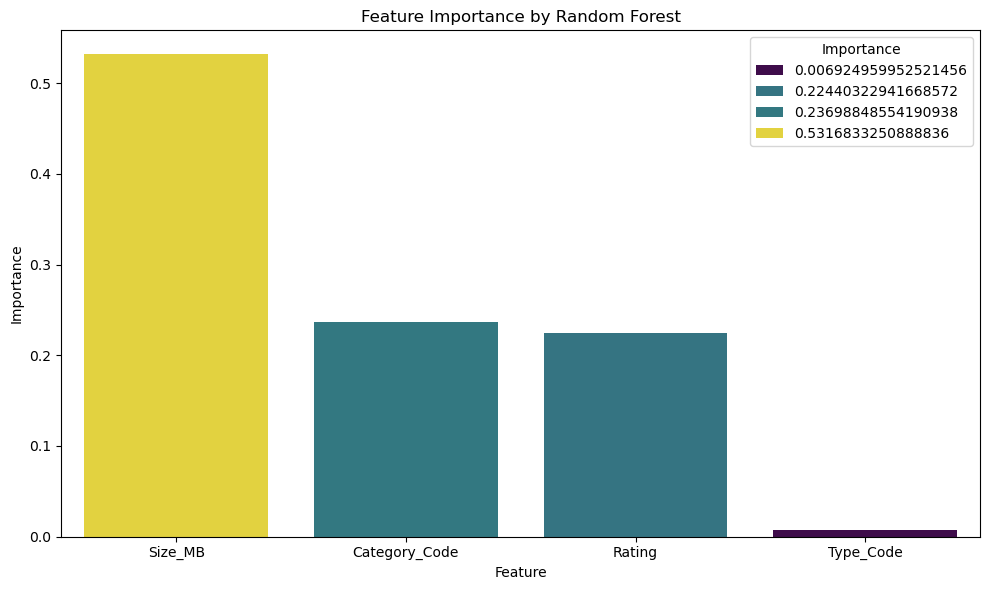

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# اهمیت ویژگی‌ها
importances = model.feature_importances_
feature_names = X_train.columns

# تبدیل به دیتافریم مرتب‌شده
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# رسم نمودار
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Importance', data=importance_df, palette='viridis',hue='Importance')
plt.title('Feature Importance by Random Forest')
plt.tight_layout()
plt.show()

**تفسیر Feature Importance:**

- Size_MB (0.53):

    - بیشترین تأثیر رو در پیش‌بینی Sentiment داشته.
    - یعنی حجم اپ بیش از نصف اهمیت مدل رو تشکیل داده!
      
  <br/>
- Category_Code (0.23):

    - نوع دسته‌بندی اپ‌ها هم نقش مهمی داشته.
 
  <br/>
- Rating (0.22):

    - امتیاز کاربرها هم تقریباً به همون اندازه مهم بوده که منطقیه.
 
  <br/>
- Type_Code (0.0069):

    - نوع رایگان/پولی تقریباً هیچ تأثیری نداشته در مدل ما.

 <br>
 
**با خروجی بدست آمده چه می‌توان کرد؟**

 حالا که فهمیدیم کدوم ویژگی‌ها مهم‌ترن، می‌تونیم:

-  ویژگی‌های کم‌اهمیت رو حذف کنیم تا مدل ساده‌تر و سریع‌تر بشه. مثلاً: Type_Code

-  روی ویژگی‌های مهم تحلیل عمیق‌تر انجام بدیم یا ازشون ویژگی‌های مشتق‌شده بسازیم (مثل گروه‌بندی Size).

-  در تفسیر خروجی مدل و تصمیم‌سازی خیلی به‌درد می‌خوره.

### SMOTE
متوازن سازی داده ها

**هدف: افزایش نمونه‌های کلاس کمتر (مثلاً کلاس 0) برای متعادل شدن با کلاس 1**

#### نصب مقدمات لازم

In [41]:
pip install imbalanced-learn

#### آماده‌سازی داده‌ها

In [42]:
X = df_clf[['Size_MB', 'Rating', 'Category_Code', 'Type_Code']]
y = df_clf['Sentiment_Label']

#### متوازن سازی کلاسها

In [43]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

#### بررسی تعادل کلاس‌ها قبل و بعد از SMOTE

In [44]:
import pandas as pd

print("قبل از SMOTE:\n", df_clf['Sentiment_Label'].value_counts())
print("\nبعد از SMOTE:\n", pd.Series(y_resampled).value_counts())

قبل از SMOTE:
 Sentiment_Label
1    28138
0    11839
Name: count, dtype: int64

بعد از SMOTE:
 Sentiment_Label
1    28138
0    28138
Name: count, dtype: int64


### آموزش مدل روی داده متوازن‌شده
استفاده از همان RandomForestClassifier

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# تقسیم داده متوازن‌شده
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# آموزش مدل
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# پیش‌بینی
y_pred = model.predict(X_test)

# ارزیابی مدل
print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))

🎯 Accuracy: 0.6746624022743426

📊 Confusion Matrix:
 [[4187 1484]
 [2178 3407]]

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.74      0.70      5671
           1       0.70      0.61      0.65      5585

    accuracy                           0.67     11256
   macro avg       0.68      0.67      0.67     11256
weighted avg       0.68      0.67      0.67     11256



**نتیجه مدل SMOTE شده**
<br>
| معیار                  | قبل از SMOTE | بعد از SMOTE |
| ---------------------- | ------------ | ------------ |
| **Accuracy**           | 0.72         |  **0.67**  |
| **Recall برای کلاس 0** |  31%       |  **74%**    |
| **Recall برای کلاس 1** |  88%        |  **61%**   |

<br>


-  قبل از SMOTE :

    -  دقت ظاهراً بالاتر بود ولی فقط چون کلاس 1 (مثبت) زیادتر بود، مدل همون رو بهتر یاد گرفته بود
<br>

-  بعد از SMOTE :

    - عملکرد روی هر دو کلاس متعادل‌تر شد
<br>

-  Recall:

   - کلاس 0 (منفی‌ها) از 31% به 74% رسید! 
<br>

-  ولی کمی دقت کلی پایین اومد، که طبیعیه

**نتیجه: مدل متعادل‌تر شد در نتیجه توی تشخیص کلاس‌های کمتر (نظرات منفی) بهتر عمل می‌کنه و این در خیلی از پروژه‌های دنیای واقعی مهم‌تر از یه دقت ظاهراً بالاست**

### XGBoost

| ابزار       | کی استفاده کنیم؟    | چرا مفیده؟                         |
| ----------- | ------------------- | ---------------------------------- |
| **XGBoost** | بعد از مدل‌های ساده | برای دقت بالاتر، قابلیت تنظیم بالا |
| **SHAP**    | بعد از مدل نهایی    | برای تفسیر خروجی و اعتمادسازی      |


#### مرحله ۱: نصب

In [46]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


#### مرحله ۲: آموزش مدل 

In [47]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# تقسیم داده‌ی SMOTE‌شده
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# ساخت مدل XGBoost
xgb_model = XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

# آموزش
xgb_model.fit(X_train, y_train)

# پیش‌بینی
y_pred = xgb_model.predict(X_test)

#### مرحله ۳: ارزیابی مدل

In [48]:
print('Accuracy:', accuracy_score(y_test,y_pred))
print('\n Confussion Matrix:\n', confusion_matrix(y_test, y_pred))
print('\n Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.6712864250177683

 Confussion Matrix:
 [[4183 1488]
 [2212 3373]]

 Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.74      0.69      5671
           1       0.69      0.60      0.65      5585

    accuracy                           0.67     11256
   macro avg       0.67      0.67      0.67     11256
weighted avg       0.67      0.67      0.67     11256



**مقایسه عملکرد دو مدل**
<br>
| معیار             | Random Forest  | XGBoost  |
| ----------------- | --------------- | ---------- |
| **Accuracy**      | 0.6747          | 0.6713     |
| **Recall کلاس 0** | 0.74            | 0.74       |
| **Recall کلاس 1** | 0.61            | 0.60       |
| **Precision کلی** | کمی بهتر        | خیلی نزدیک |


-  اگر بخوایم مطمئن شیم وقتی مدل میگه "نظر مثبته"، واقعاً هم مثبت باشه → Precision مهمه

-   اگر بخوایم مطمئن شیم نظرات منفی رو از دست ندیم → Recall کلاس 0 مهمه

**نتیجه کلی**
- عملکرد XGBoost و Random Forest تقریباً برابر بود 

-  Random Forest کمی بهتر عمل کرد (بخصوص روی Recall کلاس 1)

-  ولی XGBoost مزیت‌هایی مثل سرعت، کنترل دقیق‌تر، regularization هم داره (برای پروژه‌های بزرگ مهمه)

### SHAP

**هدف: تفسیر خروجی مدل → کدوم ویژگی باعث چه پیش‌بینی شد؟**

SHAP = SHapley Additive exPlanations

برای تفسیر مدل‌های یادگیری ماشین استفاده میشه.

#### مرحله 1: نصب

In [49]:
# ایمپورت کتابخانه
pip install shap

SyntaxError: invalid syntax (664012183.py, line 2)

#### مرحله 2: اجرای شاپ روی مدل XGBoost

In [55]:
import shap

# مقداردهی اولیه explainer
explainer = shap.Explainer(xgb_model, X_test)

# محاسبه مقدار shap برای داده تست
shap_values = explainer(X_test)

 99%|===================| 11106/11256 [00:36<00:00]        

#### مرحله 3: نمایش نمودار اهمیت ویژگی‌ها

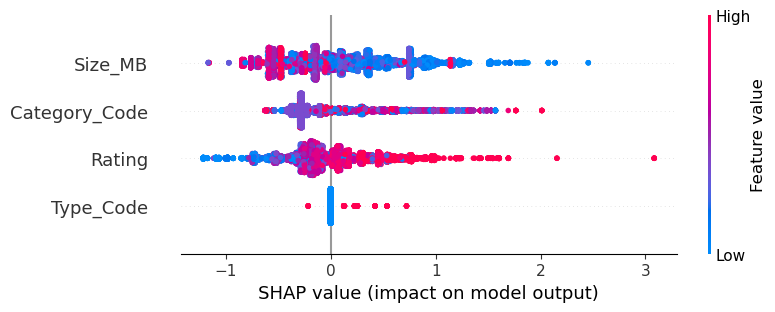

In [57]:
shap.plots.beeswarm(shap_values, max_display=10)

**تحلیل نمودار**

-  مهمترین ویژگی : Size_MB

-  قرمز: مقدار زیاد اون ویژگی

-  آبی: مقدار کم اون ویژگی

- چپ/راست: اثر مثبت یا منفی روی پیش‌بینی

 مثلا: اپ‌هایی با حجم بیشتر، بیشتر به نظر منفی ختم شدن

 **نکته:**

 Type فقط دو حالت داره 
 
- SHAP نمی‌تونه پیوسته نشونش بده
  
- مثلاً 0 → Free، 1 → Paid

- هرکدوم اثر متفاوت دارن و توی نمودار مثل دوتا خوشه جدا ظاهر می‌شن

#### مرحله 4: بررسی یک نمونه خاص

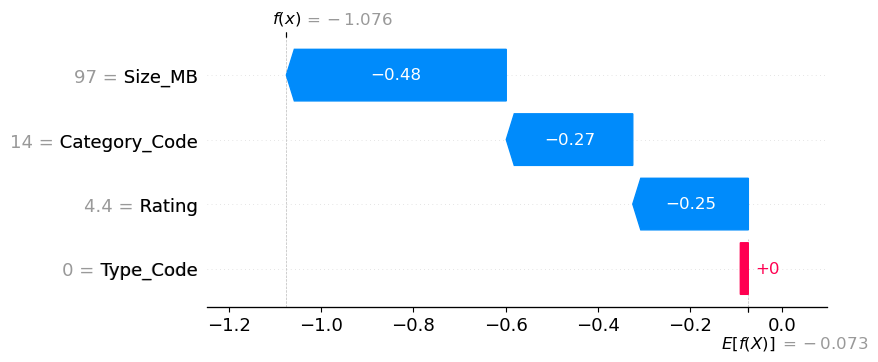

In [58]:
# بررسی اولین نمونه از X_test
shap.plots.waterfall(shap_values[0])

**تحلیل نمودار**

 این فقط برای یک کاربر خاص (نمونه خاص) است

 

### Streamlit

#### مرحله 1: ذخیره مدل

In [ ]:
import joblib

# ذخیره مدل XGBoost
joblib.dump(xgb_model, 'xgb_sentiment_model.pkl')

# اگر پردازشگر خاصی مثل encoder یا scaler داشتیم، اونم ذخیره میکنیم
# joblib.dump(scaler, 'scaler.pkl')

#### مرحله 2: ساخت فایل app_sentiment.py

import streamlit as st

import joblib

import numpy as np


#بارگذاری مد

model = joblib.load('xgb_sentiment_model.pkl')

st.set_page_config(page_title="App Review Sentiment Predictor", layout="centered")

عنوان

st.title("پیش‌بینی احساس کاربران نسبت به اپ‌ها")

st.markdown("با وارد کردن ویژگی‌های اپ، احساس کلی کاربران را پیش‌بینی کن!")

ورودی‌ها

size_mb = st.slider("حجم اپ (MB):", min_value=1.0, max_value=100.0, step=0.5)

rating = st.slider("امتیاز کاربران:", min_value=1.0, max_value=5.0, step=0.1)

category_code = st.selectbox("کد دسته‌بندی اپ:", options=[0, 1, 2, 3, 4, 5], format_func=lambda x: f"Category {x}")

type_code = st.radio("نوع اپ:", options={0: 'Free', 1: 'Paid'})

پیش‌بینی

if st.button("پیش‌بینی احساس"):
   
    features = np.array([[size_mb, rating, category_code, type_code]])
   
    prediction = model.predict(features)

    if prediction[0] == 1:
        
        st.success("احساس کلی کاربران **مثبت** است.")
   
    else:
       
        st.error("احساس کلی کاربران **منفی** است.")


####  مرحله 3: اجرای اپ در ترمینال

streamlit run app_sentiment.py